In [1]:
# If running on Colab: install dependencies (safe to re-run).
!pip -q install torch matplotlib

# Homework (Week 3): Scaled Dot-Product Attention

## Goal
Implement **scaled dot-product attention** from scratch using only PyTorch tensor operations, and build intuition by visualizing the attention weights.

## What you will submit
- This completed notebook
- Output of the **Tests / Self-check** section showing all tests passed

## Rules
- Do **not** use `torch.nn.MultiheadAttention`
- Do **not** use any external attention implementation
- You may use `torch.softmax`, matrix multiplication, broadcasting, masking

## Required interface
Implement:
- `scaled_dot_product_attention(q, k, v, mask=None)` returning `(output, weights)`

Where:
- `q`: shape `(B, Tq, D)`
- `k`: shape `(B, Tk, D)`
- `v`: shape `(B, Tk, Dv)`
- `mask` (optional): broadcastable to `(B, Tq, Tk)` with **1 for keep**, **0 for mask**

###  Dimension definitions:
-  B  = batch size (number of sequences processed in parallel)
- Tq = query sequence length (number of query positions)
- Tk = key/value sequence length (number of key/value positions)
- D  = embedding dimension (dimensionality of queries and keys)
- Dv = value dimension (dimensionality of values, often equals D)


## Key formulas
Let $Q \in \mathbb{R}^{B \times T_q \times D}$, $K \in \mathbb{R}^{B \times T_k \times D}$, $V \in \mathbb{R}^{B \times T_k \times D_v}$.

### 1) Scores
$$
S = \frac{QK^\top}{\sqrt{D}} \in \mathbb{R}^{B \times T_q \times T_k}
$$

### 2) Masking (optional)
We use a mask with **1 = keep**, **0 = mask**. We block masked positions by adding a large negative value before softmax:
$$
S' = \mathrm{where}(mask = 1,\; S,\; -\infty)
$$
In code we approximate $-\infty$ with something like `-1e9`.

### 3) Weights
$$
W = \mathrm{softmax}(S',\; \mathrm{dim}=-1)
$$
For each query position, weights form a probability distribution: $\sum_j W_{b,i,j} = 1$.

### 4) Output
$$
O = WV \in \mathbb{R}^{B \times T_q \times D_v}
$$


## Visual intuition resources
Good web pages with diagrams/figures:
- Illustrated Transformer (Jalammar): https://jalammar.github.io/illustrated-transformer/
- Illustrated GPT-2 (Jalammar): https://jalammar.github.io/illustrated-gpt2/

In this notebook you will generate your own attention visualizations (heatmaps + a simple block diagram).


In [2]:
import math
from typing import Optional, Tuple

import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

## Diagram (generated in-code)
This cell draws an original, minimal diagram of the computation flow.


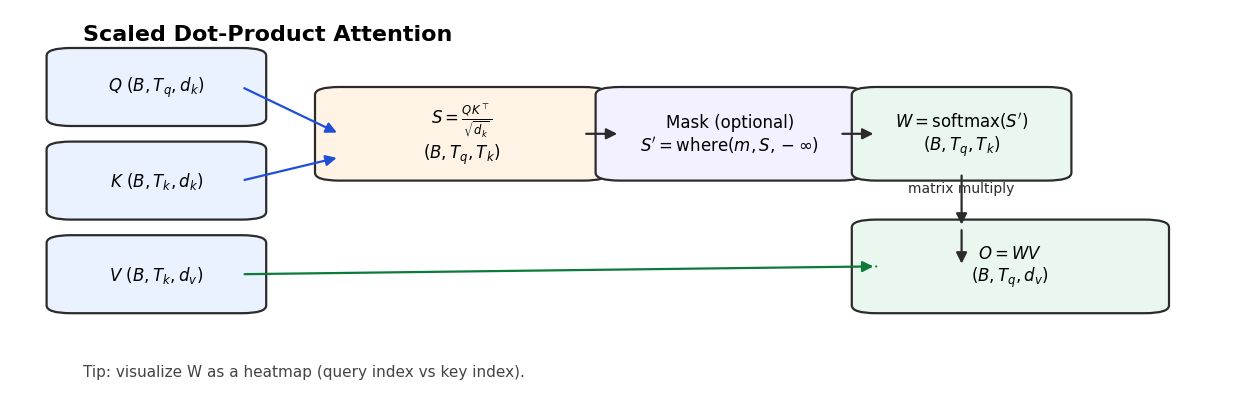

In [3]:
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

def plot_attention_block_diagram_pretty():
    fig, ax = plt.subplots(figsize=(12.5, 4.2))
    ax.set_axis_off()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    def box(x, y, w, h, text, fc="#F7F7F7", ec="#2B2B2B", lw=1.6, fs=12):
        p = FancyBboxPatch(
            (x, y), w, h,
            boxstyle="round,pad=0.02,rounding_size=0.02",
            linewidth=lw, edgecolor=ec, facecolor=fc
        )
        ax.add_patch(p)
        ax.text(x + w/2, y + h/2, text, ha="center", va="center", fontsize=fs)
        return (x, y, w, h)

    def center_right(b):  # (x, y, w, h)
        x, y, w, h = b
        return (x + w, y + h/2)

    def center_left(b):
        x, y, w, h = b
        return (x, y + h/2)

    def arrow(p1, p2, text=None, text_offset=(0, 0.03), color="#2B2B2B", rad=0.0):
        a = FancyArrowPatch(
            p1, p2,
            arrowstyle="-|>", mutation_scale=16,
            linewidth=1.6, color=color,
            connectionstyle=f"arc3,rad={rad}"
        )
        ax.add_patch(a)
        if text is not None:
            mx = (p1[0] + p2[0]) / 2 + text_offset[0]
            my = (p1[1] + p2[1]) / 2 + text_offset[1]
            ax.text(mx, my, text, ha="center", va="center", fontsize=10, color=color)

    # Layout (axis-fraction coordinates)
    q = box(0.05, 0.72, 0.14, 0.16, r"$Q\ (B,T_q,d_k)$", fc="#EAF2FF")
    k = box(0.05, 0.48, 0.14, 0.16, r"$K\ (B,T_k,d_k)$", fc="#EAF2FF")
    v = box(0.05, 0.24, 0.14, 0.16, r"$V\ (B,T_k,d_v)$", fc="#EAF2FF")

    # Scores path
    scores = box(
        0.27, 0.58, 0.20, 0.20,
        r"$S=\frac{QK^\top}{\sqrt{d_k}}$" + "\n" + r"$(B,T_q,T_k)$",
        fc="#FFF3E6"
    )
    mask = box(
        0.50, 0.58, 0.18, 0.20,
        r"Mask (optional)" + "\n" + r"$S'=\mathrm{where}(m, S, -\infty)$",
        fc="#F3F0FF"
    )
    softmax = box(
        0.71, 0.58, 0.14, 0.20,
        r"$W=\mathrm{softmax}(S')$" + "\n" + r"$(B,T_q,T_k)$",
        fc="#E9F7EF"
    )

    # Output path
    out = box(
        0.71, 0.24, 0.22, 0.20,
        r"$O=WV$" + "\n" + r"$(B,T_q,d_v)$",
        fc="#E9F7EF"
    )

    # Arrows (Q,K -> scores)
    arrow(center_right(q), (0.27, 0.68), color="#1F4ED8")
    arrow(center_right(k), (0.27, 0.62), color="#1F4ED8")

    # scores -> mask -> softmax
    arrow(center_right(scores), center_left(mask))
    arrow(center_right(mask), center_left(softmax))

    # V into output; W into output
    arrow(center_right(v), (0.71, 0.34), color="#0B7A3B")
    arrow((0.78, 0.58), (0.78, 0.44), text="matrix multiply", text_offset=(0.0, 0.03), rad=0.0)
    arrow((0.78, 0.44), (0.78, 0.34), rad=0.0)
    arrow((0.71, 0.34), center_left(out), color="#0B7A3B")

    ax.text(0.06, 0.92, "Scaled Dot-Product Attention", fontsize=16, weight="bold")
    ax.text(0.06, 0.06, "Tip: visualize W as a heatmap (query index vs key index).", fontsize=11, color="#444444")

    plt.tight_layout()
    plt.show()

plot_attention_block_diagram_pretty()

## Part 1 — Implement scaled dot-product attention (TODO)
Implement the standard formula:

$$
\mathrm{Attention}(Q,K,V) = \mathrm{softmax}\left(\frac{QK^\top}{\sqrt{D}} + M\right)V
$$

Where masking is applied by setting $M_{b,i,j} = -\infty$ when a position is masked.

### Requirements
- Must support batching (B dimension)
- Must support `Tq != Tk`
- Must apply scaling by `sqrt(D)` where D is the last dim of Q/K
- Must return:
  - `output`: shape `(B, Tq, Dv)`
  - `weights`: shape `(B, Tq, Tk)` with probabilities that sum to 1 over last dim


In [4]:
import torch
from torch import nn
from typing import Optional, Tuple

def scaled_dot_product_attention(
    q: torch.Tensor,
    k: torch.Tensor,
    v: torch.Tensor,
    mask: Optional[torch.Tensor] = None,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Scaled dot-product attention.

    Args:
        q: (B, Tq, D) queries
        k: (B, Tk, D) keys
        v: (B, Tk, Dv) values
        mask: optional, broadcastable to (B, Tq, Tk), 1=keep, 0=mask

    Returns:
        output: (B, Tq, Dv)
        weights: (B, Tq, Tk)
    """
    # Step 1: scaling factor
    D = q.size(-1)
    scale = D ** 0.5  # sqrt(D)

    # Step 2: compute raw attention scores
    # (B, Tq, D) @ (B, D, Tk) -> (B, Tq, Tk)
    scores = torch.bmm(q, k.transpose(1, 2)) / scale

    # Step 3: apply mask (if provided)
    if mask is not None:
        # Mask should be broadcastable to (B, Tq, Tk)
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Step 4: softmax over keys dimension
    weights = torch.softmax(scores, dim=-1)  # (B, Tq, Tk)

    # Step 5: weighted sum over values
    # (B, Tq, Tk) @ (B, Tk, Dv) -> (B, Tq, Dv)
    output = torch.bmm(weights, v)

    return output, weights


### Quick smoke test
Run the cell below right after implementing your function. It creates small tensors, calls your function, and prints shapes + values so you can sanity-check before moving on.

In [5]:
# Quick smoke test — run this right after implementing your function
# Creates tiny tensors so you can see exactly what's happening

# Example 1: Minimal case (batch=1, 3 queries, 4 keys, dim=2)
q_test = torch.tensor([[[1.0, 0.0],
                         [0.0, 1.0],
                         [1.0, 1.0]]])  # (1, 3, 2)

k_test = torch.tensor([[[1.0, 0.0],
                         [0.0, 1.0],
                         [1.0, 1.0],
                         [0.5, 0.5]]])  # (1, 4, 2)

v_test = torch.tensor([[[10.0, 0.0],
                         [0.0, 10.0],
                         [5.0, 5.0],
                         [1.0, 1.0]]])  # (1, 4, 2)

out, w = scaled_dot_product_attention(q_test, k_test, v_test)

print("=== Smoke Test ===")
print(f"Q shape: {q_test.shape}  ->  (B=1, Tq=3, D=2)")
print(f"K shape: {k_test.shape}  ->  (B=1, Tk=4, D=2)")
print(f"V shape: {v_test.shape}  ->  (B=1, Tk=4, Dv=2)")
print(f"Output shape: {out.shape}  (expected: (1, 3, 2))")
print(f"Weights shape: {w.shape}  (expected: (1, 3, 4))")
print()
print("Attention weights (each row sums to 1):")
print(w[0])
print(f"Row sums: {w[0].sum(dim=-1)}")
print()
print("Output:")
print(out[0])

# Example 2: With a mask — block the last 2 keys
mask_test = torch.tensor([[[1, 1, 0, 0],
                            [1, 1, 0, 0],
                            [1, 1, 0, 0]]], dtype=torch.float32)  # (1, 3, 4)

out_m, w_m = scaled_dot_product_attention(q_test, k_test, v_test, mask=mask_test)

print("\n=== With Mask (block last 2 keys) ===")
print("Attention weights (masked positions should be ~0):")
print(w_m[0])
print(f"Row sums: {w_m[0].sum(dim=-1)}")

=== Smoke Test ===
Q shape: torch.Size([1, 3, 2])  ->  (B=1, Tq=3, D=2)
K shape: torch.Size([1, 4, 2])  ->  (B=1, Tk=4, D=2)
V shape: torch.Size([1, 4, 2])  ->  (B=1, Tk=4, Dv=2)
Output shape: torch.Size([1, 3, 2])  (expected: (1, 3, 2))
Weights shape: torch.Size([1, 3, 4])  (expected: (1, 3, 4))

Attention weights (each row sums to 1):
tensor([[0.3130, 0.1543, 0.3130, 0.2198],
        [0.1543, 0.3130, 0.3130, 0.2198],
        [0.1989, 0.1989, 0.4034, 0.1989]])
Row sums: tensor([1.0000, 1.0000, 1.0000])

Output:
tensor([[4.9142, 3.3277],
        [3.3277, 4.9142],
        [4.2045, 4.2045]])

=== With Mask (block last 2 keys) ===
Attention weights (masked positions should be ~0):
tensor([[0.6698, 0.3302, 0.0000, 0.0000],
        [0.3302, 0.6698, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000]])
Row sums: tensor([1., 1., 1.])


## Part 2 — Masks (helper functions provided)
Convention: mask is **1 for keep**, **0 for mask** and must be broadcastable to `(B, Tq, Tk)`.

- **Padding mask** blocks some keys for every query
- **Causal mask** blocks future keys (autoregressive)


In [6]:
def make_padding_mask(keep: torch.Tensor, Tq: int) -> torch.Tensor:
    keep = keep.to(dtype=torch.float32)
    return keep[:, None, :].expand(-1, Tq, -1)

def make_causal_mask(Tq: int, Tk: int, device=None) -> torch.Tensor:
    m = torch.ones((Tq, Tk), dtype=torch.float32, device=device)
    m = torch.tril(m)
    return m[None, :, :]


## Part 3 — Visualization helpers (provided)
We plot attention weights $W$ as a heatmap.

- Y-axis: query positions (0..Tq-1)
- X-axis: key positions (0..Tk-1)

Brighter means higher attention probability.


In [7]:
def plot_attention_heatmap(weights: torch.Tensor, title: str = '') -> None:
    w = weights.detach().float().cpu()[0]
    plt.figure(figsize=(7, 4))
    plt.imshow(w, aspect='auto', interpolation='nearest')
    plt.colorbar(label='attention probability')
    plt.xlabel('key index')
    plt.ylabel('query index')
    plt.title(title)
    plt.tight_layout()
    plt.show()


## Part 4 — Sanity experiments (run after you implement attention)
### Experiment A: Random attention + masks
You should see weights change when you apply padding/causal masks.


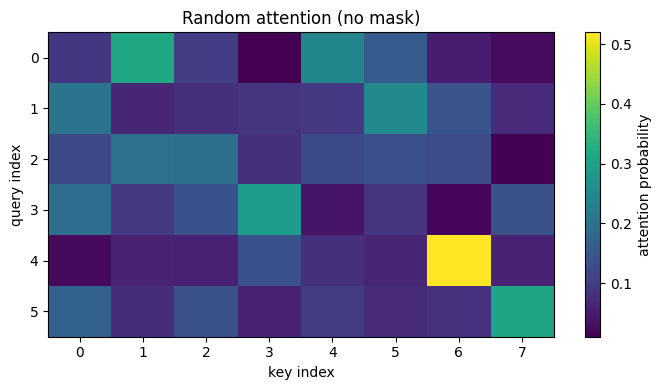

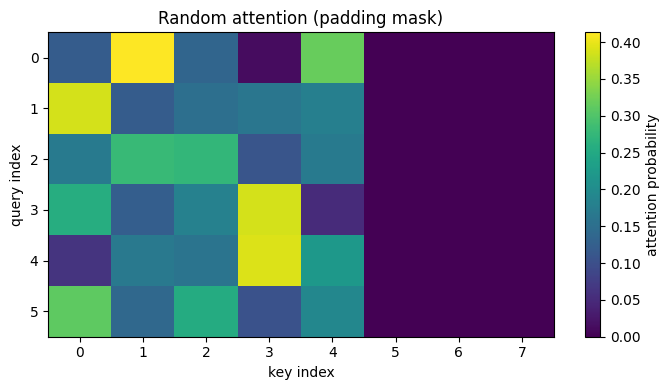

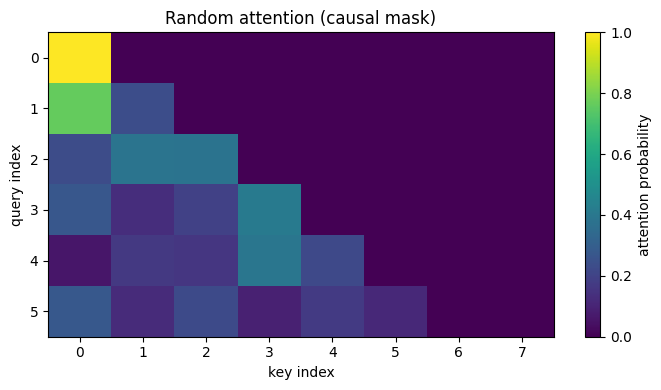

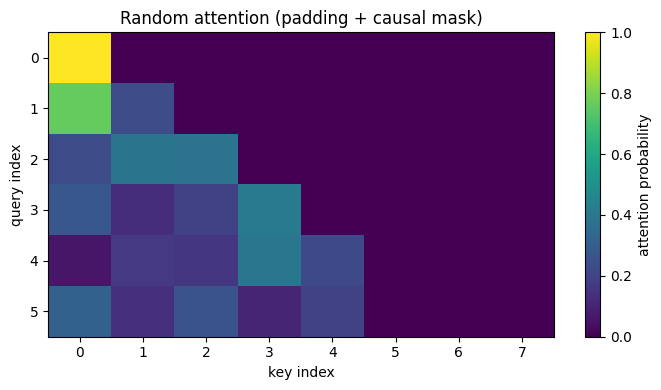

In [8]:
B, Tq, Tk, D, Dv = 2, 6, 8, 16, 16
q = torch.randn(B, Tq, D, device=device)
k = torch.randn(B, Tk, D, device=device)
v = torch.randn(B, Tk, Dv, device=device)

padding_keep = torch.tensor([[1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0]], device=device)
pad_mask = make_padding_mask(padding_keep, Tq=Tq)
causal_mask = make_causal_mask(Tq=Tq, Tk=Tk, device=device)

out0, w0 = scaled_dot_product_attention(q, k, v, mask=None)
plot_attention_heatmap(w0, title='Random attention (no mask)')

out1, w1 = scaled_dot_product_attention(q, k, v, mask=pad_mask)
plot_attention_heatmap(w1, title='Random attention (padding mask)')

out2, w2 = scaled_dot_product_attention(q, k, v, mask=causal_mask)
plot_attention_heatmap(w2, title='Random attention (causal mask)')

out3, w3 = scaled_dot_product_attention(q, k, v, mask=pad_mask * causal_mask)
plot_attention_heatmap(w3, title='Random attention (padding + causal mask)')


### Experiment B: A toy example that should look diagonal
We build $Q$ and $K$ so that each query is most similar to the matching key.
If attention is correct, the heatmap should be strongly diagonal.


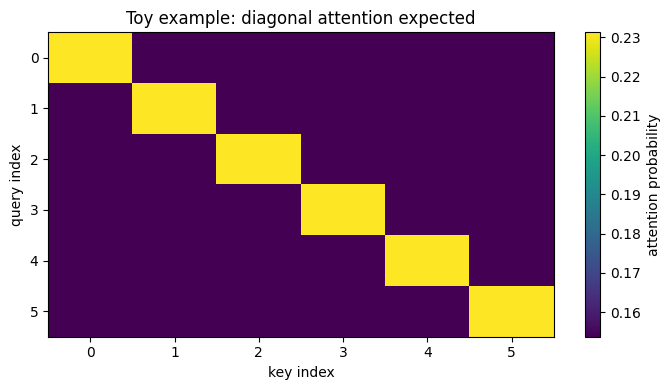

In [9]:
B, Tq, Tk = 1, 6, 6
D = 6
Dv = 4

q = torch.eye(Tq, D, device=device)[None, :, :]
k = torch.eye(Tk, D, device=device)[None, :, :]
v = torch.randn(B, Tk, Dv, device=device)

out, w = scaled_dot_product_attention(q, k, v, mask=None)
plot_attention_heatmap(w, title='Toy example: diagonal attention expected')


# Tests / Self-check
Run this section before submitting.

The tests check:
- correctness of shapes
- probabilities sum to 1
- masking works (masked probs ~ 0)
- numerical agreement with a reference implementation


In [10]:
def _assert(cond: bool, msg: str) -> None:
    if not cond:
        raise AssertionError(msg)

def reference_attention(q, k, v, mask=None):
    D = q.shape[-1]
    scores = (q @ k.transpose(-2, -1)) / math.sqrt(D)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    weights = torch.softmax(scores, dim=-1)
    out = weights @ v
    return out, weights

def test_shapes():
    B, Tq, Tk, D, Dv = 3, 5, 7, 11, 13
    q = torch.randn(B, Tq, D, device=device)
    k = torch.randn(B, Tk, D, device=device)
    v = torch.randn(B, Tk, Dv, device=device)
    out, w = scaled_dot_product_attention(q, k, v, mask=None)
    _assert(out.shape == (B, Tq, Dv), f'output shape wrong: {out.shape}')
    _assert(w.shape == (B, Tq, Tk), f'weights shape wrong: {w.shape}')

def test_probabilities_sum_to_one():
    B, Tq, Tk, D = 2, 4, 6, 8
    q = torch.randn(B, Tq, D, device=device)
    k = torch.randn(B, Tk, D, device=device)
    v = torch.randn(B, Tk, D, device=device)
    _, w = scaled_dot_product_attention(q, k, v, mask=None)
    s = w.sum(dim=-1)
    _assert(torch.allclose(s, torch.ones_like(s), atol=1e-5), 'attention weights must sum to 1')

def test_masking_makes_probabilities_zeroish():
    B, Tq, Tk, D = 1, 3, 5, 4
    q = torch.randn(B, Tq, D, device=device)
    k = torch.randn(B, Tk, D, device=device)
    v = torch.randn(B, Tk, D, device=device)
    mask = torch.ones((B, Tq, Tk), device=device)
    mask[..., -2:] = 0
    _, w = scaled_dot_product_attention(q, k, v, mask=mask)
    masked_probs = w[..., -2:]
    _assert(float(masked_probs.max().item()) < 1e-4, 'masked positions should have ~0 probability')

def test_matches_reference():
    B, Tq, Tk, D, Dv = 2, 4, 6, 8, 5
    q = torch.randn(B, Tq, D, device=device)
    k = torch.randn(B, Tk, D, device=device)
    v = torch.randn(B, Tk, Dv, device=device)
    keep = torch.randint(0, 2, (B, Tk), device=device)
    mask = make_padding_mask(keep, Tq=Tq)

    out1, w1 = scaled_dot_product_attention(q, k, v, mask=mask)
    out2, w2 = reference_attention(q, k, v, mask=mask)

    _assert(torch.allclose(w1, w2, atol=1e-5, rtol=1e-5), 'weights do not match reference')
    _assert(torch.allclose(out1, out2, atol=1e-5, rtol=1e-5), 'output does not match reference')

def run_all_tests():
    tests = [
        test_shapes,
        test_probabilities_sum_to_one,
        test_masking_makes_probabilities_zeroish,
        test_matches_reference,
    ]
    for t in tests:
        t()
        print('✓ PASSED:', t.__name__)

    print('\n' + '='*80)
    print('🎉 ALL TESTS PASSED! Your homework is ready for submission.')
    print('='*80)

run_all_tests()

✓ PASSED: test_shapes
✓ PASSED: test_probabilities_sum_to_one
✓ PASSED: test_masking_makes_probabilities_zeroish
✓ PASSED: test_matches_reference

🎉 ALL TESTS PASSED! Your homework is ready for submission.
